In [1]:
!pip install click

Looking in indexes: http://mirrors.tencentyun.com/pypi/simple


In [2]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
import random
import numpy as np
import pandas as pd
import torch
import torchvision
from torch import nn
from IPython import display
from torch.utils import data
from d2l import torch as d2l
from matplotlib import pyplot as plt
from utils import d2lhelper
from utils import downloader

In [3]:
train_dataset_url = 'http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_train.csv'
test_dataset_url = 'http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_test.csv'

train_dataset = downloader.download_file(train_dataset_url, '../data')
test_dataset = downloader.download_file(test_dataset_url, '../data')

assert train_dataset != -1
assert test_dataset != -1

train_dataset, test_dataset

start downloading: http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_train.csv => ../data/kaggle_house_pred_train.csv
file size: 449.900 KB
  file already exists ../data/kaggle_house_pred_train.csv
start downloading: http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_test.csv => ../data/kaggle_house_pred_test.csv
file size: 440.845 KB
  file already exists ../data/kaggle_house_pred_test.csv


('../data/kaggle_house_pred_train.csv', '../data/kaggle_house_pred_test.csv')

In [4]:
train_data = pd.read_csv(train_dataset)
test_data = pd.read_csv(test_dataset)

print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [5]:
# 看一看前四组数据
print(train_data.iloc[0:4, :])

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml  

In [6]:
# 删除第一个 column: ID，同时删除训练数据的最后一列：房价
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [7]:
# 若无法获得测试数据，则可根据训练数据计算均值和标准差
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 在标准化数据之后，所有均值消失，因此我们可以将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [8]:
# “Dummy_na=True”将“na”（缺失值）视为有效的特征值，并为其创建指示符特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [9]:
# 再来看一下前四组数据，我们可以发现原来的 column 被拓展了，离散值经过了独热编码
print(all_features.iloc[0:4, :])

   MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
0    0.067320    -0.184443 -0.217841     0.646073    -0.507197   1.046078   
1   -0.873466     0.458096 -0.072032    -0.063174     2.187904   0.154737   
2    0.067320    -0.055935  0.137173     0.646073    -0.507197   0.980053   
3    0.302516    -0.398622 -0.078371     0.646073    -0.507197  -1.859033   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  SaleType_Oth  \
0      0.896679    0.523038    0.580708    -0.29303  ...             0   
1     -0.395536   -0.569893    1.177709    -0.29303  ...             0   
2      0.848819    0.333448    0.097840    -0.29303  ...             0   
3     -0.682695   -0.569893   -0.494771    -0.29303  ...             0   

   SaleType_WD  SaleType_nan  SaleCondition_Abnorml  SaleCondition_AdjLand  \
0            1             0                      0                      0   
1            1             0                      0                      0   
2        

In [10]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

train_features.shape, test_features.shape, train_labels.shape

(torch.Size([1460, 331]), torch.Size([1459, 331]), torch.Size([1460, 1]))

In [11]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features, 1))
    return net

In [12]:
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

In [13]:
def train(net, train_features, train_labels, test_features, test_labels, 
          num_epochs, learning_rate, weight_decay, batch_size):
    # 返回 train_loss 和 test loss
    train_ls, test_ls = [], []
    # 下面这句用的是 pytorch 的 DataLoader
    # Pytorch 的 DataLoader 在一轮读完之后不会失效，所以可以定义在这里，也就是 epoch 的外面
    # train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs): 
        train_iter = d2lhelper.load_data_iter(train_features, train_labels, batch_size)
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [14]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [15]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

折1，训练log rmse0.170532, 验证log rmse0.157145
折2，训练log rmse0.162108, 验证log rmse0.188838
折3，训练log rmse0.163985, 验证log rmse0.168601
折4，训练log rmse0.168063, 验证log rmse0.154832
折5，训练log rmse0.163683, 验证log rmse0.183103
5-折验证: 平均训练log rmse: 0.165674, 平均验证log rmse: 0.170504


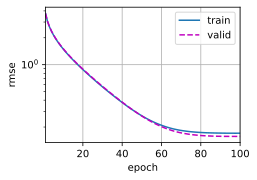

In [16]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')